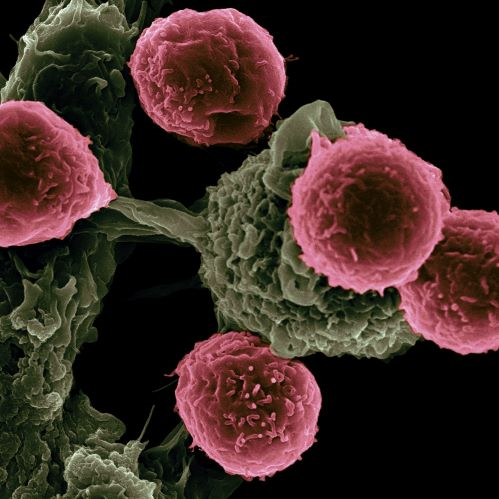

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/cancer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

### Brief introduction of Melanoma

The most common form of cancer is skin cancer. Despite being the least prevalent skin cancer, melanoma is responsible for 75 percent of skin cancer deaths. According to the American Cancer Society, over 100,000 new cases of melanoma will be diagnosed in 2020. Nearly 7,000 people are estimated to die as a result of the outbreak. Early and reliable identification, as with other cancers, will improve treatment effectiveness, which could be aided by data science.

Dermatologists currently examine each of a patient's moles to spot outlier lesions or "ugly ducklings" that are most likely to be melanoma. 

### Problem Statement

Using patient-level contextual knowledge in the creation of image analysis tools to help clinical dermatologists better on how to spot outlier lesions  .

.



### Importing necessary libraries

In [1]:
import os
import gc
import time
import tqdm
import random

import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Import datasets which comprises of the image dataset,csv format and its metadata

In [2]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test  = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

train.shape, test.shape

((33126, 8), (10982, 5))

In [3]:
train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [4]:
test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [5]:
train.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [6]:
test.isnull().sum()

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

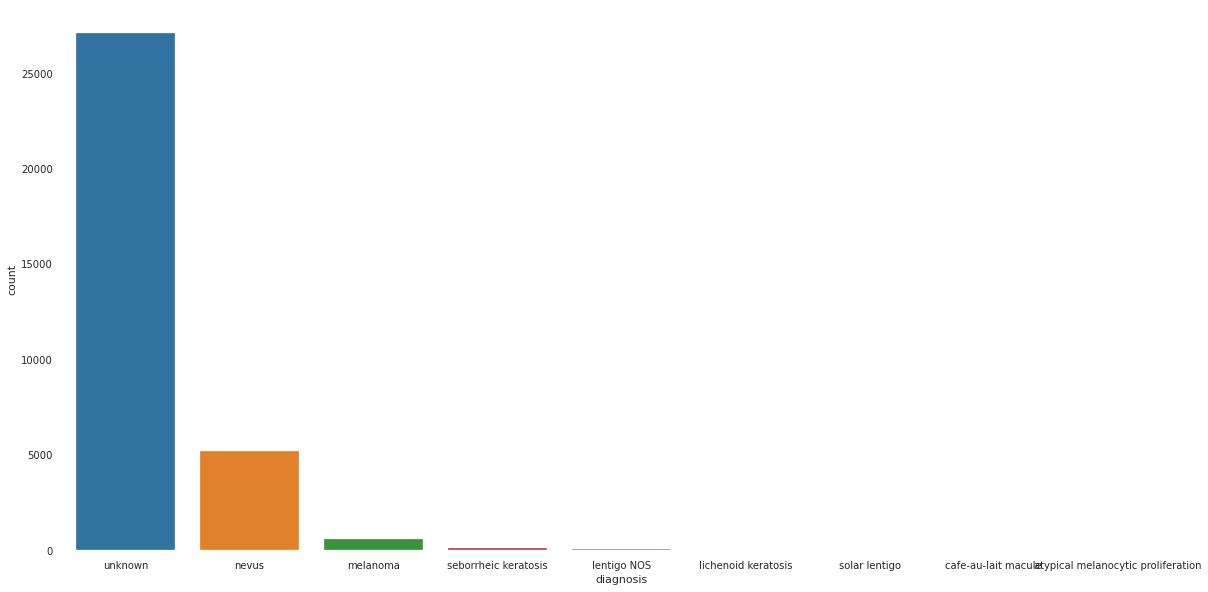

In [10]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x = train['diagnosis'])

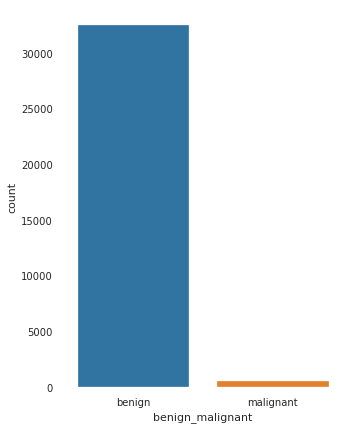

In [11]:
plt.figure(figsize=(5,7))
ax = sns.countplot(x = train['benign_malignant'])

In [12]:
train.dtypes
test.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
dtype: object

**Converting the test and train tables to integer for prediction**

In [13]:
del train['image_name']
del test['image_name']

del train['patient_id']
del test['patient_id']

In [14]:
train.columns

Index(['sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis',
       'benign_malignant', 'target'],
      dtype='object')

In [15]:
test.columns

Index(['sex', 'age_approx', 'anatom_site_general_challenge'], dtype='object')

In [16]:
train['sex'] = train['sex'].astype('category')
test['sex'] = test['sex'].astype('category')

train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].astype('category')
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].astype('category')

train['age_approx'] = train['age_approx'].astype('category')
test['age_approx'] = test['age_approx'].astype('category')

train['diagnosis'] = train['diagnosis'].astype('category')

train['benign_malignant'] = train['benign_malignant'].astype('category')

train['target'] = train['target'].astype('category')


In [17]:
train['sex_Cat'] = train['sex'].cat.codes
test['sex_Cat'] = test['sex'].cat.codes

train['anatom_site_general_challenge_Cat'] = train['anatom_site_general_challenge'].cat.codes
test['anatom_site_general_challenge_Cat'] = test['anatom_site_general_challenge'].cat.codes

train['age_approx_Cat'] = train['age_approx'].cat.codes
test['age_approx_Cat'] = test['age_approx'].cat.codes

train['diagnosis_Cat'] = train['diagnosis'].cat.codes

train['benign_malignant_Cat'] = train['benign_malignant'].cat.codes

train['target_Cat'] = train['target'].cat.codes

# Another method
#label = LabelEncoder()
#label.fit(train['benign_malignant'])
#train['benign_malignant'] = label.transform(train['benign_malignant'])

In [18]:
train

,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_Cat,anatom_site_general_challenge_Cat,age_approx_Cat,diagnosis_Cat,benign_malignant_Cat,target_Cat
0,male,45.0,head/neck,unknown,benign,0,1,0,8,8,0,0
1,female,45.0,upper extremity,unknown,benign,0,0,5,8,8,0,0
2,female,50.0,lower extremity,nevus,benign,0,0,1,9,5,0,0
3,female,45.0,head/neck,unknown,benign,0,0,0,8,8,0,0
4,female,55.0,upper extremity,unknown,benign,0,0,5,10,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
33121,male,50.0,torso,unknown,benign,0,1,4,9,8,0,0
33122,male,65.0,torso,unknown,benign,0,1,4,12,8,0,0
33123,male,20.0,lower extremity,unknown,benign,0,1,1,3,8,0,0
33124,male,50.0,lower extremity,unknown,benign,0,1,1,9,8,0,0


Drop old columns

In [19]:
del train['sex']
del train['age_approx']
del train['anatom_site_general_challenge']

del test['sex']
del test['age_approx']
del test['anatom_site_general_challenge']

In [20]:
del train['diagnosis'] # not in test
del train['benign_malignant'] # not in test

del train['diagnosis_Cat'] # not in test
del train['benign_malignant_Cat'] # not in test

In [21]:
cols_test = list(test.columns) # to be sure train columns are same with test columns except target

In [22]:
X = train[cols_test] # Features
y = train.target 

In [23]:
X

,sex_Cat,anatom_site_general_challenge_Cat,age_approx_Cat
0,1,0,8
1,0,5,8
2,0,1,9
3,0,0,8
4,0,5,10
...,...,...,...
33121,1,4,9
33122,1,4,12
33123,1,1,3
33124,1,1,9


In [24]:
test

,sex_Cat,anatom_site_general_challenge_Cat,age_approx_Cat
0,1,-1,12
1,1,1,6
2,0,4,9
3,0,4,8
4,0,1,7
...,...,...,...
10977,1,4,6
10978,1,4,5
10979,1,5,3
10980,1,1,11


# Data split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state = 4)

In [26]:
VAL_SIZE = 0.15
EPOCHS = 20
BATCH_SIZE = 16

In [27]:
print('TRAIN: {} & {}'.format(X_train.shape, y_train.shape))
print('TEST:  {} & {}'.format(X_test.shape, y_test.shape))

val_len = int(X_train.shape[0]*VAL_SIZE)

TRAIN: (24844, 3) & (24844,)
TEST:  (8282, 3) & (8282,)


In [28]:
class_weight_array = class_weight.compute_class_weight('balanced', 
                                                       np.unique(y_train), 
                                                       y_train)
print('\nClass weights: {}'.format(class_weight_array)) 

# Class weights as dictionary for Keras
keys = [0,1] 
class_weight_dict = dict(zip(keys, class_weight_array.T))
print('\nClass weights dict: {}'.format(class_weight_dict))


Class weights: [ 0.5089732  28.36073059]

Class weights dict: {0: 0.5089732033106613, 1: 28.360730593607308}


We have almost 60 times more of label 1 (malignant) than label 0 (benign) as shown by class weights  
- 0: ~0.51
- 1: ~28.4

In [29]:
n_features = len(X_train.columns)
n_features

3

Convert to arrays for Keras processing

In [30]:
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

# Models

In [31]:
model_0 = Sequential()
model_0.add(Dense(64, activation='relu', input_dim = n_features ) )
model_0.add(Dense(32, activation='relu'))
model_0.add(Dense(16, activation='relu'))
model_0.add(Dense(3, activation='softmax'))

model_1 = Sequential()
model_1.add(Dense(128, activation='relu', input_dim = n_features ) )
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(3, activation='softmax'))

In [32]:
models = [model_0, model_1]

Train on 21118 samples, validate on 3726 samples
Epoch 1/20
21118/21118 [==============================] - 2s 115us/step - loss: 0.7147 - accuracy: 0.4577 - val_loss: 0.6850 - val_accuracy: 0.4173
Epoch 2/20
21118/21118 [==============================] - 2s 99us/step - loss: 0.6699 - accuracy: 0.4394 - val_loss: 0.4699 - val_accuracy: 0.9061
Epoch 3/20
21118/21118 [==============================] - 2s 99us/step - loss: 0.6686 - accuracy: 0.5013 - val_loss: 0.7007 - val_accuracy: 0.4563
Epoch 4/20
21118/21118 [==============================] - 2s 99us/step - loss: 0.6628 - accuracy: 0.5031 - val_loss: 0.5697 - val_accuracy: 0.7821
Epoch 5/20
21118/21118 [==============================] - 2s 97us/step - loss: 0.6568 - accuracy: 0.5628 - val_loss: 0.6132 - val_accuracy: 0.6600
Epoch 6/20
21118/21118 [==============================] - 2s 97us/step - loss: 0.6543 - accuracy: 0.5702 - val_loss: 0.6221 - val_accuracy: 0.6583
Epoch 7/20
21118/21118 [==============================] - 2s 96us/st

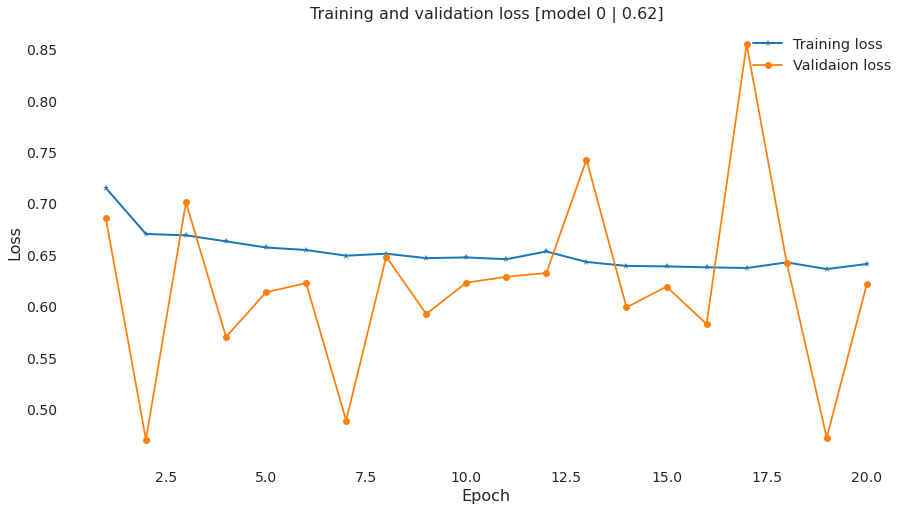

<Figure size 576x396 with 0 Axes>

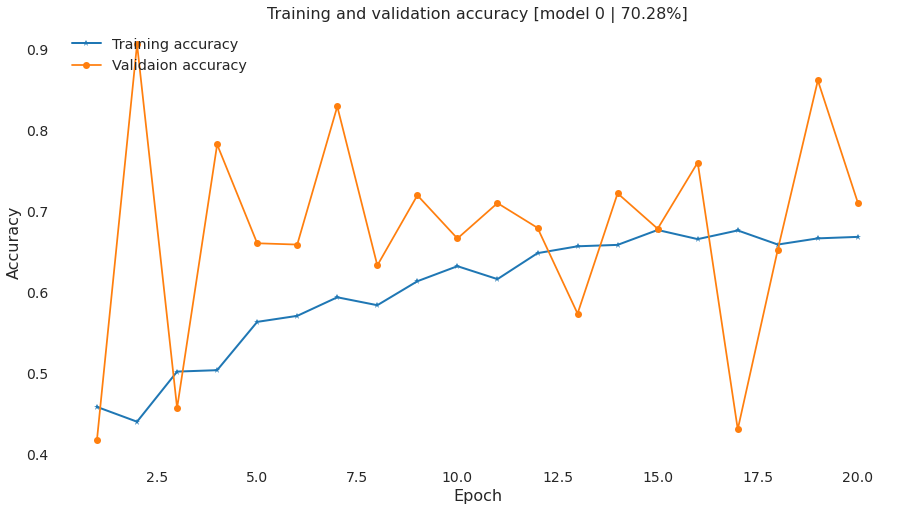

Train on 21118 samples, validate on 3726 samples
Epoch 1/20
21118/21118 [==============================] - 2s 108us/step - loss: 0.7683 - accuracy: 0.2651 - val_loss: 0.6497 - val_accuracy: 0.2517
Epoch 2/20
21118/21118 [==============================] - 2s 101us/step - loss: 0.7143 - accuracy: 0.2970 - val_loss: 0.6846 - val_accuracy: 0.5676
Epoch 3/20
21118/21118 [==============================] - 2s 99us/step - loss: 0.6769 - accuracy: 0.4490 - val_loss: 0.8624 - val_accuracy: 0.1581
Epoch 4/20
21118/21118 [==============================] - 2s 99us/step - loss: 0.6689 - accuracy: 0.4897 - val_loss: 0.7550 - val_accuracy: 0.4189
Epoch 5/20
21118/21118 [==============================] - 2s 102us/step - loss: 0.6903 - accuracy: 0.5208 - val_loss: 0.6744 - val_accuracy: 0.5778
Epoch 6/20
21118/21118 [==============================] - 2s 103us/step - loss: 0.6501 - accuracy: 0.5914 - val_loss: 0.6772 - val_accuracy: 0.6033
Epoch 7/20
21118/21118 [==============================] - 2s 97us

<Figure size 576x396 with 0 Axes>

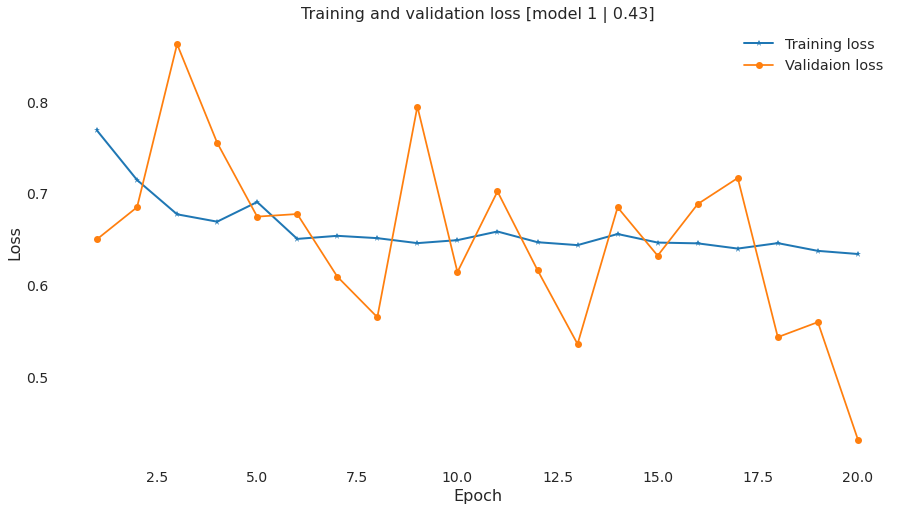

<Figure size 576x396 with 0 Axes>

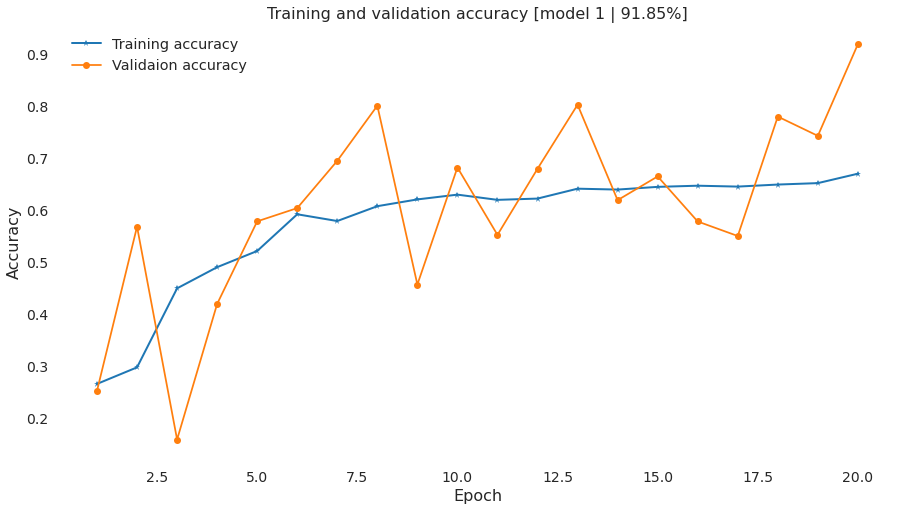

<Figure size 576x396 with 0 Axes>

In [33]:
for m,model in enumerate(models):
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )

    X_val = X_train[:val_len]
    y_val = y_train[:val_len]

    X_train_cut = X_train[val_len:]
    y_train_cut = y_train[val_len:]
    
    # callback to stop the training if no improvement for 5 consecutive epochs
    callback = keras.callbacks.EarlyStopping(monitor='loss', 
                                             patience=5)

    history = model.fit(X_train_cut, y_train_cut, 
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        class_weight=class_weight_dict,
                        validation_data=(X_val, y_val),
                        callbacks=[callback],
                        #verbose=0
                       )
    
    result = model.evaluate(X_test, y_test)
    print('\nMODEL {}:\n{}'.format(m,result))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    metrics = history.history['accuracy']
    epochs = range(1, len(metrics) + 1) 

    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, color='tab:blue', linestyle='-', linewidth=2, marker='*', label='Training loss')
    plt.plot(epochs, val_loss, color='tab:orange', linestyle='-', marker='o', label='Validaion loss')
    plt.title('Training and validation loss [model {} | {:.2f}]'.format(m,result[0]), fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize='x-large')
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(15,8))
    plt.plot(epochs, accuracy, color='tab:blue', linestyle='-', linewidth=2, marker='*', label='Training accuracy')
    plt.plot(epochs, val_accuracy, color='tab:orange', linestyle='-', marker='o', label='Validaion accuracy')
    plt.title('Training and validation accuracy [model {} | {:.2f}%]'.format(m,result[1]*100), fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc='upper left', fontsize='x-large')
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()


### References

* Photo by <a href="https://unsplash.com/@nci?   utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/cancer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  